# Exploratory Data Analysis (EDA) - MovieLens 1M
**Objective:** Analyze dataset dynamics, identify pathologies (sparsity, cold-start), and determine modeling implications later on

In [ ]:
import os
import urllib.request
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import sparse

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
DATA_URL = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
DATA_DIR = "../data"
DATASET_DIR = os.path.join(DATA_DIR, "ml-1m")
ZIP_PATH = os.path.join(DATA_DIR, "ml-1m.zip")

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

if not os.path.exists(DATASET_DIR):
    if not os.path.exists(ZIP_PATH):
        urllib.request.urlretrieve(DATA_URL, ZIP_PATH)
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)

## 1. Data Loading and Basic Statistics
We are using the **MovieLens 1M** dataset. It contains ~1M ratings from ~6k users on ~4k movies
* **Users:** Demographics 
* **Movies:** Titles and Genres 
* **Ratings:** 1-5 scale

In [3]:
ratings = pd.read_csv(
    os.path.join(DATASET_DIR, "ratings.dat"),
    sep="::",
    engine="python",
    names=["user_id", "item_id", "rating", "timestamp"],
    encoding="latin-1"
)

movies = pd.read_csv(
    os.path.join(DATASET_DIR, "movies.dat"),
    sep="::",
    engine="python",
    names=["item_id", "title", "genres"],
    encoding="latin-1"
)

users = pd.read_csv(
    os.path.join(DATASET_DIR, "users.dat"),
    sep="::",
    engine="python",
    names=["user_id", "gender", "age", "occupation", "zip"],
    encoding="latin-1"
)

ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')

In [4]:
print(f"Ratings: {len(ratings):_} , Users: {ratings['user_id'].nunique():_} , Items: {ratings['item_id'].nunique():_}")
print(f"Time span: {ratings['datetime'].min().date()} to {ratings['datetime'].max().date()}") 

Ratings: 1_000_209 , Users: 6_040 , Items: 3_706
Time span: 2000-04-25 to 2003-02-28


### Analysis & Modeling Implications
* **Sparsity (95.5%):** The matrix is highly sparse (only ~4.5% full).

We cannot use dense matrix operations (too much memory)

High sparsity suggests that Collaborative Filtering (User-User/Item-Item) might suffer from limited overlap between users. Matrix Factorization will likely perform better by filling in these gaps

In [5]:
n_users = ratings['user_id'].nunique()
n_items = ratings['item_id'].nunique()
n_interactions = len(ratings)
sparsity = 1 - (n_interactions / (n_users * n_items))


print(f"total ratings: {n_interactions:_}")
print(f"unique users: {n_users:_}")
print(f"unique movies: {n_items:_}")
print(f"sparsity: {sparsity:.3f}")
print(f"Avg ratings per user: {n_interactions/n_users:.1f}")
print(f"Avg ratings per movie: {n_interactions/n_items:.1f}")

total ratings: 1_000_209
unique users: 6_040
unique movies: 3_706
sparsity: 0.955
Avg ratings per user: 165.6
Avg ratings per movie: 269.9


## 2. Global Rating Distribution
Understanding the distribution of the target variable (ratings 1-5)

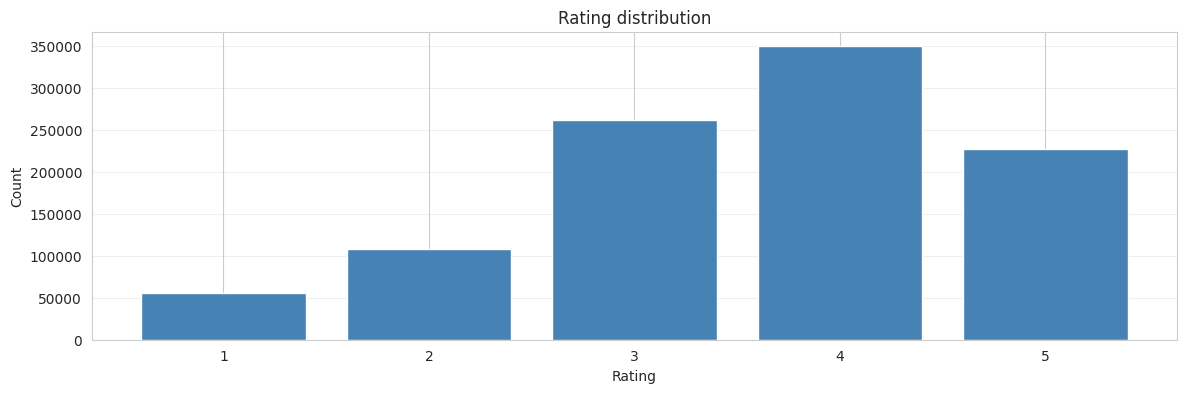

Mean rating: 3.58
Median rating: 4.0

Rating distribution
5 stars: 22.6%
4 stars: 34.9%
3 stars: 26.1%
2 stars: 10.8%
1 stars: 5.6%


In [6]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))

rating_counts = ratings['rating'].value_counts().sort_index()
ax.bar(rating_counts.index, rating_counts.values, color='steelblue')
ax.set_xlabel('Rating')
ax.set_ylabel('Count')
ax.set_title('Rating distribution')
ax.grid(axis='y', alpha=0.3)

plt.savefig('../experiments/figures/01_rating_distribution.png')
plt.show()

print(f"Mean rating: {ratings['rating'].mean():.2f}")
print(f"Median rating: {ratings['rating'].median():.1f}")

print('\nRating distribution')
print(f"5 stars: {(rating_counts[5]/len(ratings)*100):.1f}%")
print(f"4 stars: {(rating_counts[4]/len(ratings)*100):.1f}%")
print(f"3 stars: {(rating_counts[3]/len(ratings)*100):.1f}%")
print(f"2 stars: {(rating_counts[2]/len(ratings)*100):.1f}%")
print(f"1 stars: {(rating_counts[1]/len(ratings)*100):.1f}%")

The distribution is left-skewed. 4 and 5-star ratings make up  around 58% of interactions. The model might learn a "positivity bias" (predicting high ratings for everyone). We should consider whether to treat this as a Regression task (minimizing MSE) or a Ranking task (where we just want to get the top items right)

## 3. Activity Distributions
Analyzing how many ratings typical users give and how many ratings typical items receive

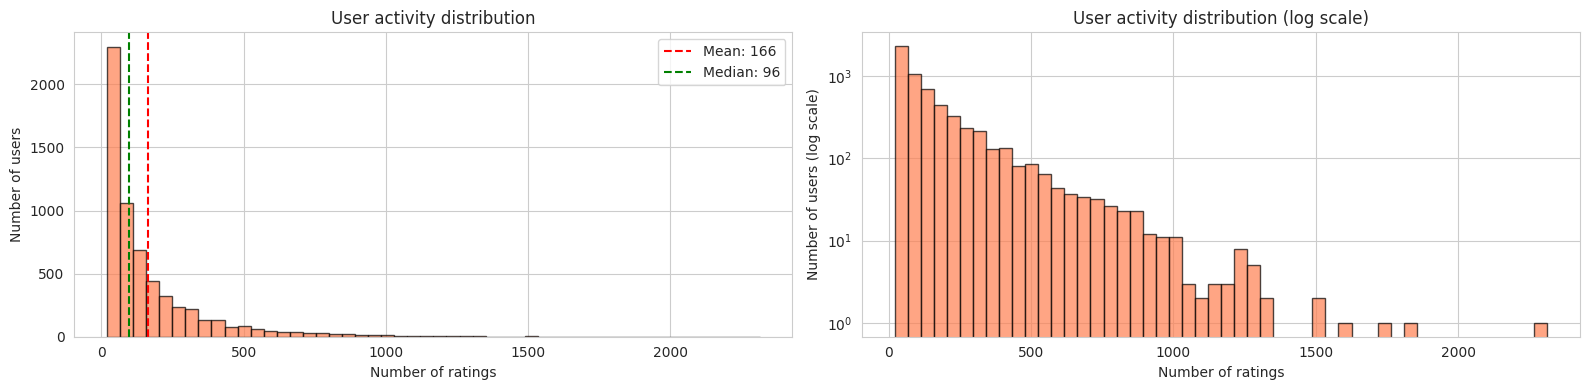


User activity stats
Min: 20 , Max: 2314
Mean: 165.6 , Median: 96.0
Q1: 44 , Q3: 208


In [7]:
user_activity = ratings.groupby('user_id').size()

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

axes[0].hist(user_activity, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of ratings')
axes[0].set_ylabel('Number of users')
axes[0].set_title('User activity distribution')
axes[0].axvline(user_activity.mean(), color='red', linestyle='--', label=f'Mean: {user_activity.mean():.0f}')
axes[0].axvline(user_activity.median(), color='green', linestyle='--', label=f'Median: {user_activity.median():.0f}')
axes[0].legend()

axes[1].hist(user_activity, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Number of ratings')
axes[1].set_ylabel('Number of users (log scale)')
axes[1].set_title('User activity distribution (log scale)')
axes[1].set_yscale('log')

plt.tight_layout()
plt.savefig('../experiments/figures/01_user_activity.png')
plt.show()

print(f"\nUser activity stats")
print(f"Min: {user_activity.min()} , Max: {user_activity.max()}")
print(f"Mean: {user_activity.mean():.1f} , Median: {user_activity.median():.1f}")
print(f"Q1: {user_activity.quantile(0.25):.0f} , Q3: {user_activity.quantile(0.75):.0f}")


* Distribution is highly right-skewed. Mean is significantly higher than Median. It means that small portion of power users are skewing average activity upward
* Minimal amount of ratings per user is 20, meaning that we don't have cold-start problem here
* A small group of power users (those with over 1000 ratings) contribute disproportionately. To prevent them from dominating we have to prioritize per-user metrics, rather than global ones

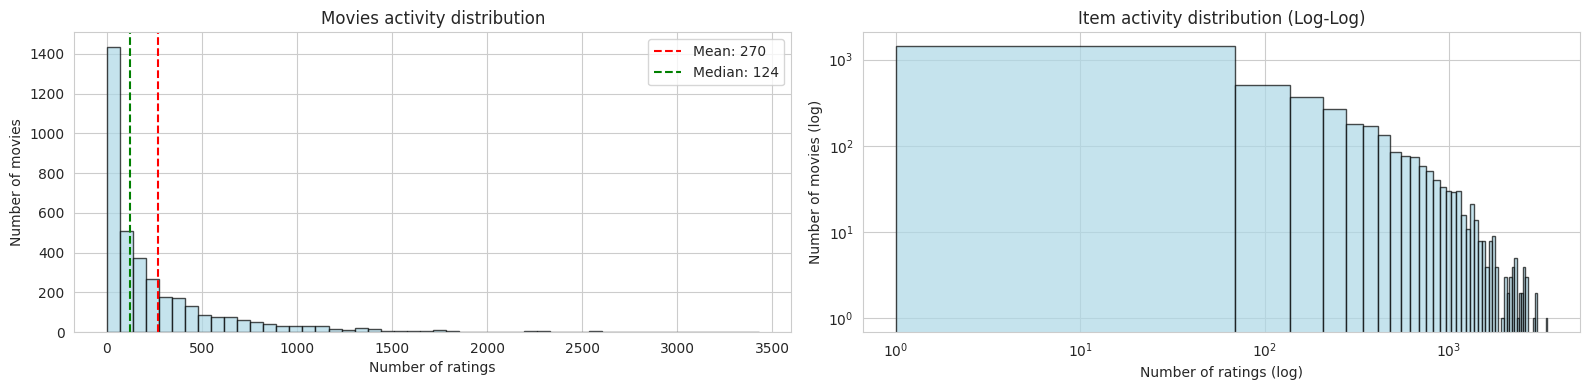


Movie activity stats
Min: 1 , Max: 3428
Mean: 269.9 , Median: 123.5
Q1: 33 , Q3: 350


In [8]:
item_activity = ratings.groupby('item_id').size()

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

axes[0].hist(item_activity, bins=50, color='lightblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of ratings')
axes[0].set_ylabel('Number of movies')
axes[0].set_title('Movies activity distribution')
axes[0].axvline(item_activity.mean(), color='red', linestyle='--', label=f'Mean: {item_activity.mean():.0f}')
axes[0].axvline(item_activity.median(), color='green', linestyle='--', label=f'Median: {item_activity.median():.0f}')
axes[0].legend()

axes[1].hist(item_activity, bins=50, color='lightblue', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Number of ratings (log)')
axes[1].set_ylabel('Number of movies (log)')
axes[1].set_title('Item activity distribution (Log-Log)')
axes[1].set_xscale('log')
axes[1].set_yscale('log')

plt.tight_layout()
plt.savefig('../experiments/figures/01_item_activity.png')
plt.show()

print(f"\nMovie activity stats")
print(f"Min: {item_activity.min()} , Max: {item_activity.max()}")
print(f"Mean: {item_activity.mean():.1f} , Median: {item_activity.median():.1f}")
print(f"Q1: {item_activity.quantile(0.25):.0f} , Q3: {item_activity.quantile(0.75):.0f}")


* Distribution is significantly more skewed than the user activity (mean is more than dould of median). We can conclude that a few "blockbuster" movies inflate the average
* Unlike users, items have true cold-start problem. Minimum amount of ratings is 1. For items in Q1 (<33 ratings) data is too sparse for reliable neighbor-finding
* Top movies are rated by huge percentage of user base. Baseline of recomending only most popular iterms would be hard to beat in terms of raw accuracy, since it works for majority of interations

## Conclusion:
* Both users and items follow a Power Law distribution
* A small number of items receive the vast majority of ratings
* Baseline that recommends only popular iterms will be difficult to beat on standard metrics (RMSE/Accuracy) but will fail to provide personalized discovery
* "Niche" items (in the tail) have very few vectors to learn from, making it hard for Matrix Factorization to learn accurate embeddings for them

## 4. Temporal Dynamics
Analyzing interaction volume over time to decide our train/test split strategy

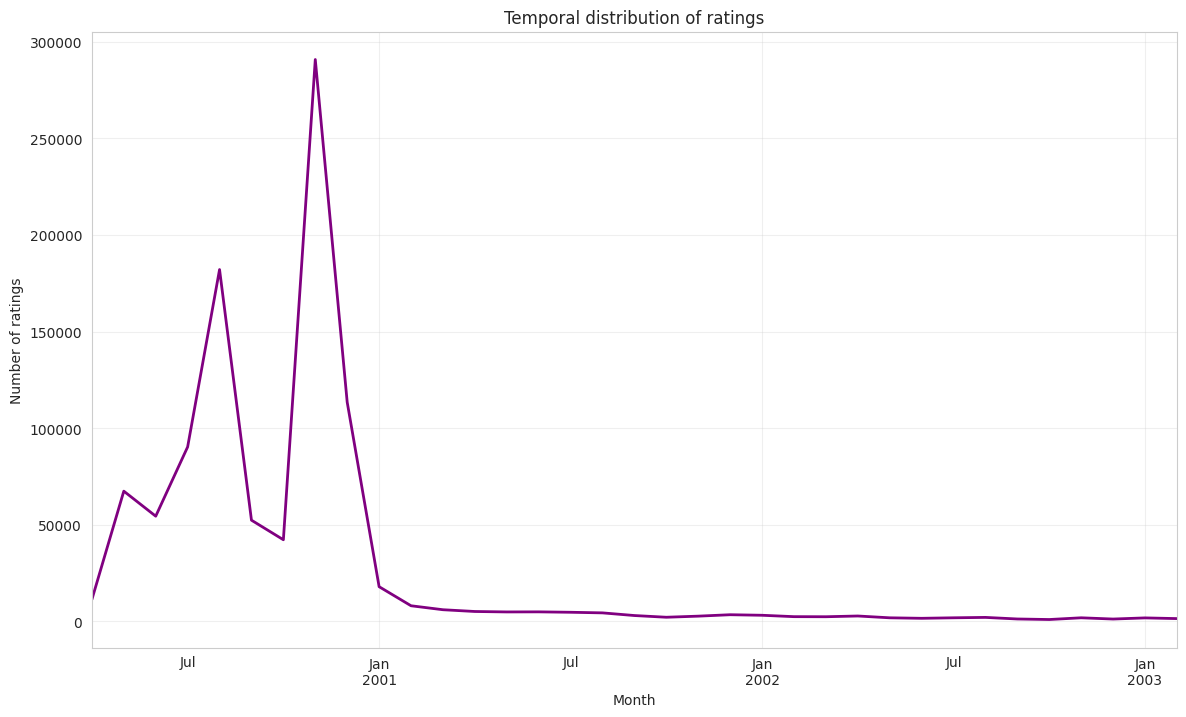

Month with most ratings: 2000-11 (290,793 ratings)
Month with lowest amount of ratings 2002-10 (1,014 ratings)


In [9]:
ratings_sorted = ratings.sort_values('datetime')
ratings_sorted['month'] = ratings_sorted['datetime'].dt.to_period('M')
monthly_counts = ratings_sorted.groupby('month').size()

fig, axes = plt.subplots(1, 1, figsize=(14, 8))

monthly_counts.plot(ax=axes, color='purple', linewidth=2)
axes.set_xlabel('Month')
axes.set_ylabel('Number of ratings')
axes.set_title('Temporal distribution of ratings')
axes.grid(alpha=0.3)

plt.savefig('../experiments/figures/01_temporal_distribution.png')
plt.show()

print(f"Month with most ratings: {monthly_counts.idxmax()} ({monthly_counts.max():,} ratings)")
print(f"Month with lowest amount of ratings {monthly_counts.idxmin()} ({monthly_counts.min():,} ratings)")

We see specific spikes (e.g., across 2000). The data is not uniformly distributed over time
* Random splitting is dangerous. If we split randomly, we leak future trends into the past
* We must use time-based split (e.g., train on first 80% of time, test on last 20%) to prevent data leakage

## 5. Cold-Start Problem
Identifying users and items with insufficient data for reliable collaborative filtering

In [29]:
cold_start_thresholds = [5, 10, 19, 20]

for threshold in cold_start_thresholds:
    cold_users = (user_activity <= threshold).sum()
    cold_items = (item_activity <= threshold).sum()
    cold_user_pct = cold_users / n_users * 100
    cold_item_pct = cold_items / n_items * 100
    
    print(f"Threshold: <= {threshold} ratings")
    print(f"cold-start users: {cold_users:,} ({cold_user_pct:.1f}%)")
    print(f"cold-start movies: {cold_items:,} ({cold_item_pct:.1f}%)")


Threshold: <= 5 ratings
cold-start users: 0 (0.0%)
cold-start movies: 329 (8.9%)
Threshold: <= 10 ratings
cold-start users: 0 (0.0%)
cold-start movies: 473 (12.8%)
Threshold: <= 19 ratings
cold-start users: 0 (0.0%)
cold-start movies: 663 (17.9%)
Threshold: <= 20 ratings
cold-start users: 86 (1.4%)
cold-start movies: 695 (18.8%)


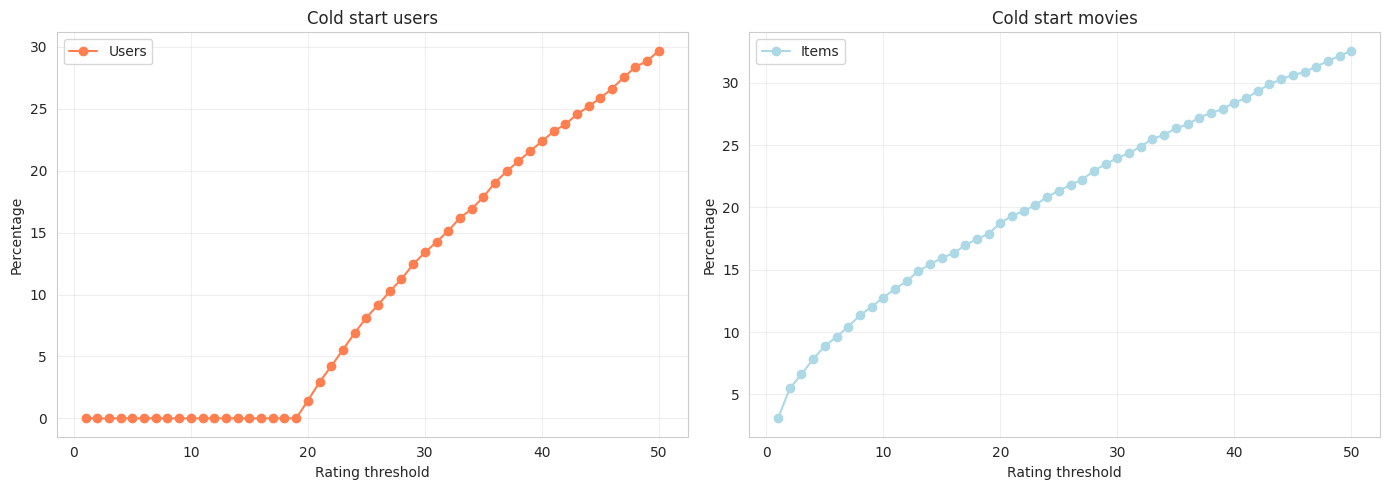

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

thresholds = range(1, 51)
cold_users_pct = [(user_activity <= t).sum() / n_users * 100 for t in thresholds]
cold_items_pct = [(item_activity <= t).sum() / n_items * 100 for t in thresholds]

axes[0].plot(thresholds, cold_users_pct, marker='o', label='Users', color='coral')
axes[0].set_xlabel('Rating threshold')
axes[0].set_ylabel('Percentage')
axes[0].set_title('Cold start users')
axes[0].grid(alpha=0.3)
axes[0].legend()

axes[1].plot(thresholds, cold_items_pct, marker='o', label='Items', color='lightblue')
axes[1].set_xlabel('Rating threshold')
axes[1].set_ylabel('Percentage')
axes[1].set_title('Cold start movies')
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.savefig('../experiments/figures/01_cold_start.png')
plt.show()



* Item Cold-Start: around ~19% of movies have fewer than 20 ratings
* Pure CF models will fail for these items. We might need Content-Based Filtering (using genre metadata) or a hybrid approach to recommend these "cold" items
* User Cold-Start: The dataset is relatively clean of cold-start users (min ratings = 20), due to pre-processing by MovieLens
* Thus, we don't need aggressive filtering for users in the training set, but we must decide how to handle "new" users in the test set who might have very few visible interactions

## 6. Inequality Problem

In [12]:
def gini_coefficient(x):
    sorted_x = np.sort(x)
    n = len(x)
    cumsum = np.cumsum(sorted_x)
    return (2 * np.sum((n - np.arange(1, n + 1) + 1) * sorted_x)) / (n * cumsum[-1]) - (n + 1) / n

user_gini = gini_coefficient(user_activity.values)
item_gini = gini_coefficient(item_activity.values)

print(f"User activity Gini: {user_gini:.3f}")
print(f"Item activity Gini: {item_gini:.3f}")

User activity Gini: -0.529
Item activity Gini: -0.634


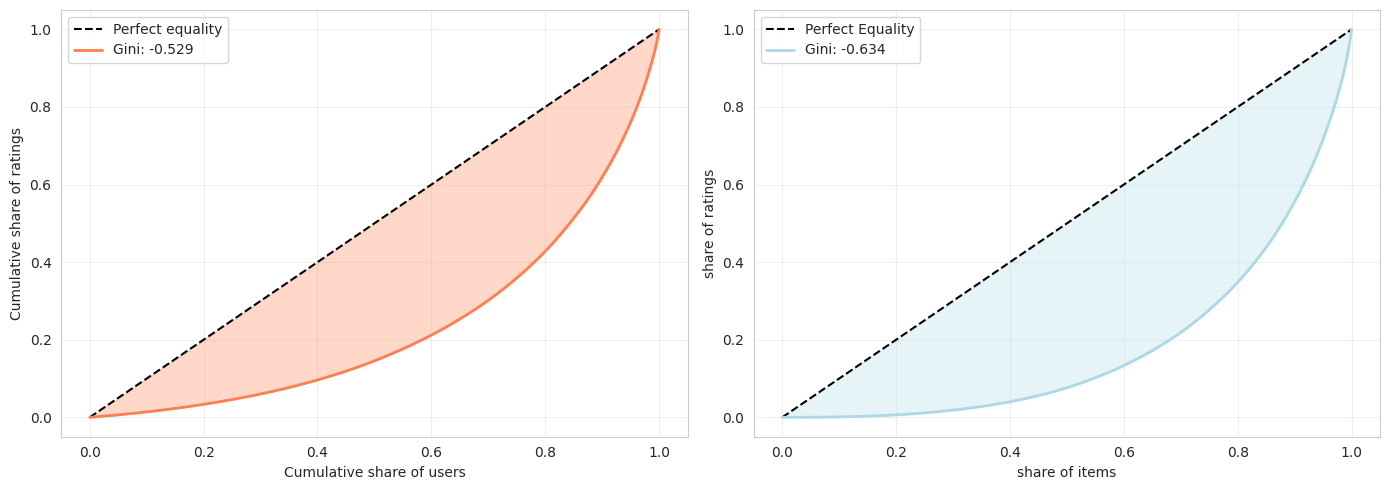

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

def lorenz_curve(x):
    sorted_x = np.sort(x)
    cumsum = np.cumsum(sorted_x)
    return np.insert(cumsum / cumsum[-1], 0, 0)

user_lorenz = lorenz_curve(user_activity.values)
axes[0].plot([0, 1], [0, 1], 'k--', label='Perfect equality')
axes[0].plot(np.linspace(0, 1, len(user_lorenz)), user_lorenz, 'coral', linewidth=2, label=f'Gini: {user_gini:.3f}')
axes[0].fill_between(np.linspace(0, 1, len(user_lorenz)), user_lorenz, np.linspace(0, 1, len(user_lorenz)), alpha=0.3, color='coral')
axes[0].set_xlabel('Cumulative share of users')
axes[0].set_ylabel('Cumulative share of ratings')
axes[0].legend()
axes[0].grid(alpha=0.3)

item_lorenz = lorenz_curve(item_activity.values)
axes[1].plot([0, 1], [0, 1], 'k--', label='Perfect Equality')
axes[1].plot(np.linspace(0, 1, len(item_lorenz)), item_lorenz, 'lightblue', linewidth=2, label=f'Gini: {item_gini:.3f}')
axes[1].fill_between(np.linspace(0, 1, len(item_lorenz)), item_lorenz, np.linspace(0, 1, len(item_lorenz)), alpha=0.3, color='lightblue')
axes[1].set_xlabel('share of items')
axes[1].set_ylabel('share of ratings')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../experiments/figures/01_gini.png')
plt.show()

In [14]:
top_k_values = [10, 50, 100, 500]
for k in top_k_values:
    top_k_items = item_activity.nlargest(k)
    top_k_ratings = top_k_items.sum()
    pct = top_k_ratings / n_interactions * 100
    print(f"Top {k} items: {top_k_ratings:_} ratings ({pct:.1f}%)")


Top 10 items: 28_017 ratings (2.8%)
Top 50 items: 109_804 ratings (11.0%)
Top 100 items: 183_142 ratings (18.3%)
Top 500 items: 530_109 ratings (53.0%)


In [15]:
top_k_values = [10, 50, 100, 1000]
for k in top_k_values:
    top_k_users = user_activity.nlargest(k)
    top_k_ratings = top_k_users.sum()
    pct = top_k_ratings / n_interactions * 100
    print(f"Top {k} items: {top_k_ratings:_} ratings ({pct:.1f}%)")


Top 10 items: 15_796 ratings (1.6%)
Top 50 items: 59_640 ratings (6.0%)
Top 100 items: 103_433 ratings (10.3%)
Top 1000 items: 515_329 ratings (51.5%)


* High values of Gini coefficient indicate high inequality.
* The top 500 items account for around 50% of all ratings (right chart). Around 1000 users are responsible for 50% of ratings (left chart)
* We need to evaluate our models not just on accuracy, but on Coverage and include Popularity bias

## 7. Item Metadata 
Since we have item cold-start issues (19% of items < 20 ratings), we can use these Genre tags to build item profiles

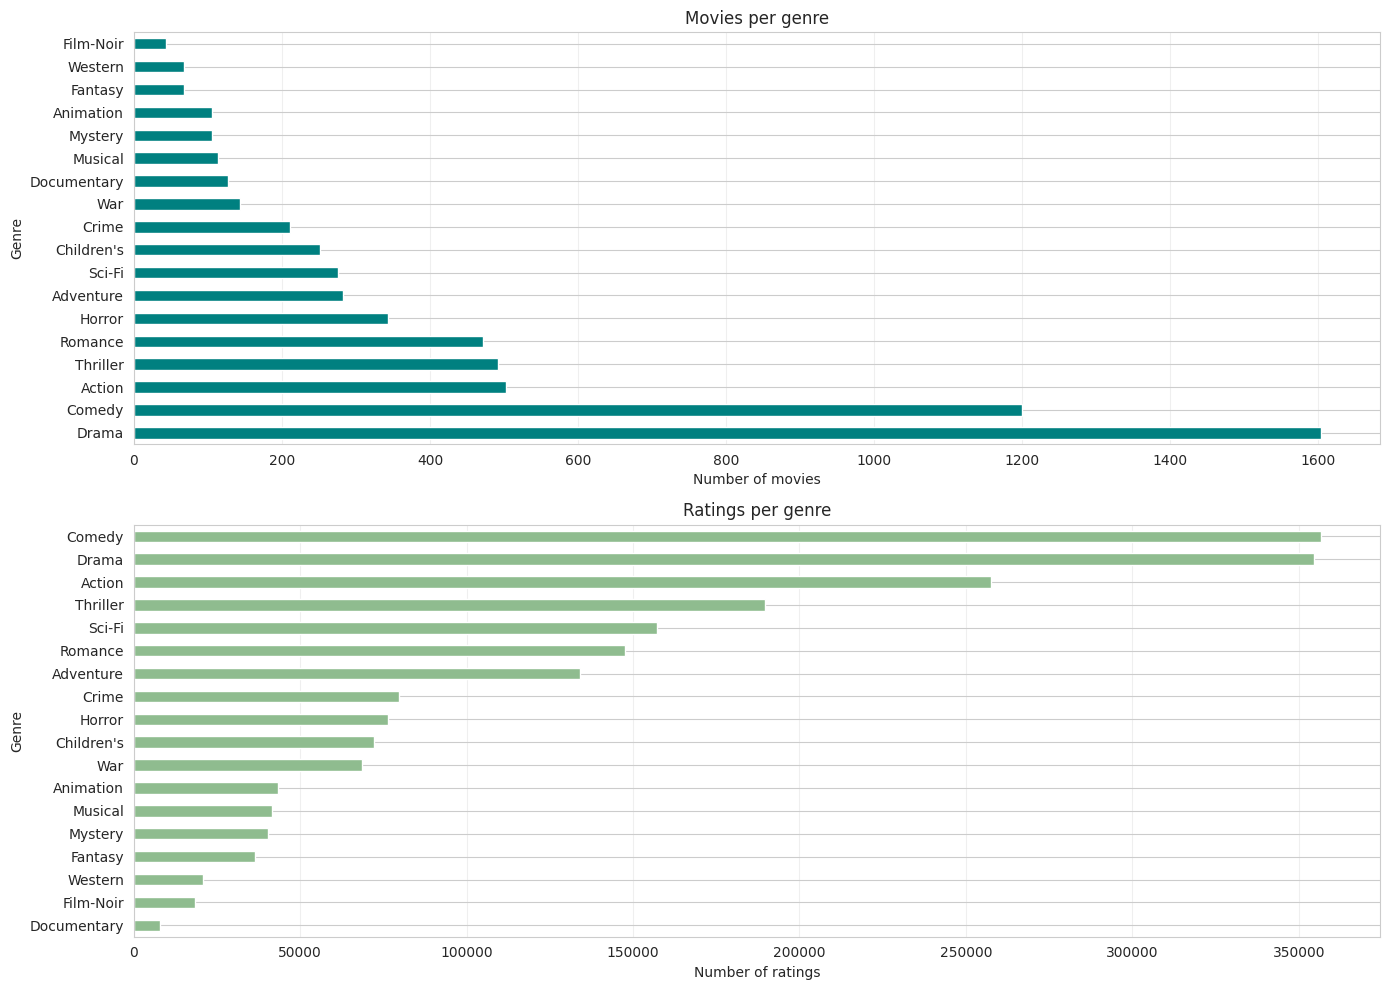

In [16]:
movies['genres_list'] = movies['genres'].str.split('|')
genre_expanded = movies.explode('genres_list')

ratings_with_genres = ratings.merge(movies[['item_id', 'genres']], on='item_id')
genre_counts = genre_expanded['genres_list'].value_counts()

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

genre_counts.plot(kind='barh', ax=axes[0], color='teal')
axes[0].set_xlabel('Number of movies')
axes[0].set_ylabel('Genre')
axes[0].set_title('Movies per genre')
axes[0].grid(axis='x', alpha=0.3)

genre_ratings = genre_expanded.merge(ratings, on='item_id').groupby('genres_list').size().sort_values(ascending=True)
genre_ratings.plot(kind='barh', ax=axes[1], color='darkseagreen')
axes[1].set_xlabel('Number of ratings')
axes[1].set_ylabel('Genre')
axes[1].set_title('Ratings per genre')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../experiments/figures/01_genres.png')
plt.show()

* Drama and Comedy are dominant genres. They have the biggest representation in amount of movies and have the highest amount of ratings. Some genres, like Sci-Fi and Thriller, though have comparatively fewer movies, but have significant amount of ratings
* Since 19% of items are cold, these tags is the only features we have for them
* It is likely that model will mostly recommend Drama and Comedy, because of their popularity
* We will use TF-IDF when creating item vectors to downgrage more common items and upweight less popular tags

# EDA Summary

## 1. Data Dynamics
Our analysis of the MovieLens 1M dataset highlights three dynamics that will define our modeling approach:

* The user-item interaction matrix is only 4.5% dense
* We observed a heavy "long-tail" distribution where the top 500 items account about 50% of all interactions
* While users are pre-filtered (min 20 ratings), approx. 19% of movies have fewer than 20 ratings
* Nearly 30% of all ratings were collected in a single month, followed by a massive drop-off in activity

## 2. Evaluation Protocol
The temporal analysis revealed that a random split is scientifically invalid for this dataset because it would leak future trends into the past

* Method: Sort all 1M interactions by timestamp
* Split Point: 80th Percentile per user as not all of them are active troughout the timeline
    * Train: First 80% of interactions
    * Test/Val: Last 20% of interactions
